https://github.com/fedhere/MLPNS2021/blob/main/HW3_LinearRegression/FitLineToGRBAfterGlow_mcmc.ipynb

The GRB afterglow is generated by a power law process --> a line is a power law in log-log space

In [ ]:
import pandas as pd
import pylab as pl
import numpy as np

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
cd /content/drive/MyDrive/Colab Notebooks

/content/drive/MyDrive/Colab Notebooks


In [ ]:
grbAG = pd.read_csv("grb050525A.csv")

In [ ]:
grbAG.head()

,filter,time,mag,magerr,upperlimit
0,V,66,13.21,0.24,0
1,V,67,12.90,0.23,0
2,V,68,12.86,0.23,0
3,V,69,13.01,0.23,0
4,V,70,12.97,0.23,0


In [ ]:
grbAG["logtime"] = np.log10(grbAG["time"]) # fit nello spazio logaritmico per avere una retta

In [ ]:
grbAG.head()

,filter,time,mag,magerr,upperlimit,logtime
0,V,66,13.21,0.24,0,1.819544
1,V,67,12.90,0.23,0,1.826075
2,V,68,12.86,0.23,0,1.832509
3,V,69,13.01,0.23,0,1.838849
4,V,70,12.97,0.23,0,1.845098


filter: diversi range in lunghezza d'onda, tipo RGB

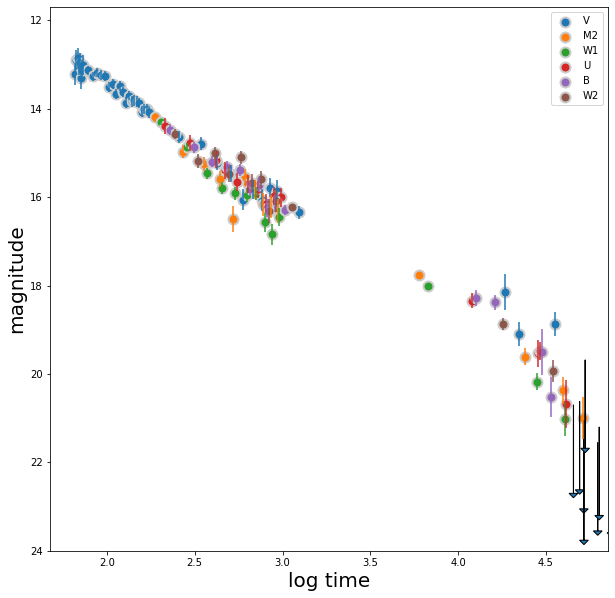

In [ ]:
ax = pl.figure(figsize = (10, 10)).add_subplot(111)

# loop sui filtri
for f in grbAG["filter"].unique(): # unique: ogni valore uguale è preso solo una volta
  pl.errorbar(grbAG.loc[grbAG["filter"] == f, "logtime"], 
              grbAG.loc[grbAG["filter"] == f, "mag"], 
              yerr=grbAG.loc[grbAG["filter"] == f, "magerr"], fmt='.', ms=0, # ms: marker size; fmt per definire il tipo di marker (s: square)
              fcolor=None, label=None)

# opzionale  
for f in grbAG["filter"].unique():
  pl.scatter(grbAG.loc[grbAG["filter"] == f, "logtime"], 
             grbAG.loc[grbAG["filter"] == f, "mag"], 
             alpha=1, s=100, linewidth=2,
             label=f,
             edgecolor='#cccccc')

# gli upperlimit sono plottati come frecce  
nuplim = grbAG.mag.isna().sum()
for i in grbAG[grbAG.upperlimit == 1].index:
    pl.arrow(grbAG.loc[i].logtime, 
             grbAG.loc[i].magerr, 0, 2, 
            head_width=0.05, head_length=0.1, ec='k')
   
pl.ylim(24,11.7) # scala invertita          
pl.legend()

pl.ylabel("magnitude", fontsize=20)
pl.xlabel("log time", fontsize=20);

# Fit Lineari

In [ ]:
# soluzione tramite equazione normale
x = grbAG[grbAG.upperlimit == 0].logtime.values
X = np.c_[np.ones((len(grbAG) - grbAG.upperlimit.sum(), 1)),
          x] # 2 colonne --> np.c_
y = grbAG.loc[grbAG.upperlimit == 0].mag

theta_best = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
# X.T --> trasposta
# dot --> prodotto matriciale

In [ ]:
np.c_[grbAG.upperlimit, grbAG.mag, grbAG.magerr]; 
# upperlimit: colonna del file costituita da un array di 0 o 1 con 1 se magerr >> degli altri errori e mag == nan

In [ ]:
#np.linalg? # linear algebra
#np.linalg.inv? # inverso della matrice

In [ ]:
print ("best fit parameters from the Normal Equation: " + 
       "intercept {:.2f}, slope {:.2f}".format(*theta_best))

best fit parameters from the Normal Equation: intercept 8.58, slope 2.51


In [ ]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()

lr.fit(X, y)
print ("best fit parameters from the sklearn LinearRegression(): " + 
       "intercept {:.2f}, slope {:.2f}".format(lr.intercept_, lr.coef_[1]))

best fit parameters from the sklearn LinearRegression(): intercept 8.58, slope 2.51


In [ ]:
from scipy.optimize import minimize

def line(x, intercept, slope):
    return slope * x + intercept
def l1(args, x, y):
    a, b = args
    return sum(np.abs(y - line(a, b, x)))


initialGuess = (10, 1)

l1Solution = minimize(l1, initialGuess, args=(x, y))
print(l1Solution)
print("")
print("best fit parameters from the minimization of L1: " + 
       "slope {:.2f}, intercept {:.2f}".format(*l1Solution.x))

      fun: 26.303692840582208
 hess_inv: array([[ 0.000116  , -0.00024307],
       [-0.00024307,  0.00129657]])
      jac: array([0.91749191, 0.        ])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 512
      nit: 12
     njev: 125
   status: 2
  success: False
        x: array([2.64056394, 8.22612506])

best fit parameters from the minimization of L1: slope 2.64, intercept 8.23


In [ ]:
def l2(args, x, y):
    '''l2 target function: returns value of l2 for given arguments and data for a line model
    arg: (array) model arguments (parameters)
    x: the exogenous variable (array)
    y: the exogenous variable (array)
    returns L2 sum of difference between prediction and data squared
    '''
    a, b = args
    return sum((y - line(a, b, x))**2)


initialGuess = (10, 1)

l2Solution = minimize(l2, initialGuess, args=(x, y))
print(l2Solution)
print("")
print("best fit parameters from the minimization of L2: " + 
       "slope {:.2f}, intercept {:.2f}".format(*l2Solution.x))

      fun: 12.825987500725489
 hess_inv: array([[ 0.00711354, -0.02029728],
       [-0.02029728,  0.06254442]])
      jac: array([1.54972076e-06, 3.57627869e-07])
  message: 'Optimization terminated successfully.'
     nfev: 28
      nit: 5
     njev: 7
   status: 0
  success: True
        x: array([2.51199977, 8.58266842])

best fit parameters from the minimization of L2: slope 2.51, intercept 8.58


In [ ]:
l2? # riporta quanto scritto tra ''' nella definizione della funzione

In [ ]:
from scipy.optimize import minimize
def line(x, b, a):
    return a * x + b 
def chi2(args, x, y, s):
    a, b = args
    return sum((y - line(x, b, a))**2/s**2)


x = grbAG[grbAG.upperlimit == 0].logtime.values
y = grbAG.loc[grbAG.upperlimit == 0].mag.values
s = grbAG.loc[grbAG.upperlimit == 0].magerr.values
initialGuess = (10, 1)

chi2Solution = minimize(chi2, initialGuess, args=(x, y, s))
print(chi2Solution)
print("")
print("best fit parameters from the minimization of the chi squared: " + 
       "slope {:.2f}, intercept {:.2f}".format(*chi2Solution.x))

      fun: 317.42066980131
 hess_inv: array([[ 0.00020206, -0.000544  ],
       [-0.000544  ,  0.00156203]])
      jac: array([1.90734863e-05, 1.14440918e-05])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 131
      nit: 6
     njev: 30
   status: 2
  success: False
        x: array([2.48019101, 8.59948749])

best fit parameters from the minimization of the chi squared: slope 2.48, intercept 8.60


In [ ]:
minimize?

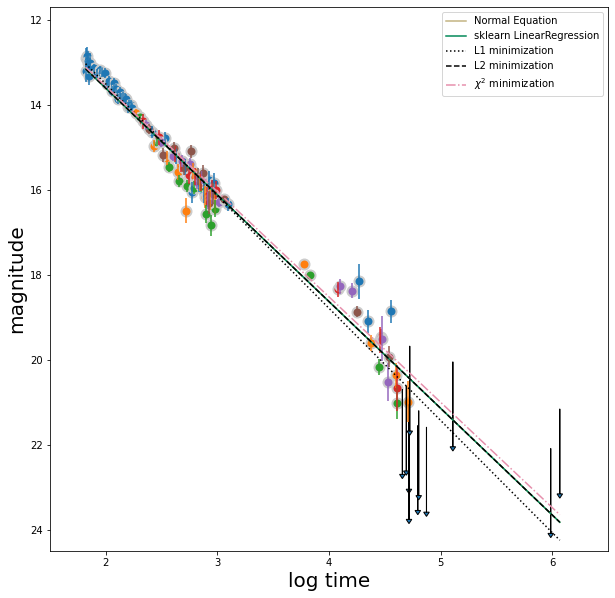

In [ ]:
ax = pl.figure(figsize=(10,10)).add_subplot(111)

def plotline(pars, x, color='k', symbol='-', label='model', ax=ax):
    slope, intercept = pars
    y = line(x, intercept, slope)
    ax.plot(x, y, ls=symbol, c=color, label=label)

for f in grbAG["filter"].unique():
    pl.errorbar(grbAG.loc[grbAG["filter"] == f, "logtime"], 
                grbAG.loc[grbAG["filter"] == f, "mag"], 
                yerr=grbAG.loc[grbAG["filter"] == f, "magerr"], fmt='.', ms=0,
                fcolor=None, label=None)
    
for f in grbAG["filter"].unique():
    pl.scatter(grbAG.loc[grbAG["filter"] == f, "logtime"], 
               grbAG.loc[grbAG["filter"] == f, "mag"], 
               alpha=1, s=100, linewidth=2,
               edgecolor='#cccccc', label=None)
    
nuplim = grbAG.mag.isna().sum()
for i in grbAG[grbAG.upperlimit == 1].index:
    pl.arrow(grbAG.loc[i].logtime, 
             grbAG.loc[i].magerr, 0, 2, 
            head_width=0.05, head_length=0.1, ec='k')
    
colors = ['C2B280', '848482', '008856', 'E68FAC', '0067A5', 'F99379', 
          '604E97', 'F6A600', 'B3446C', 
          'DCD300', '882D17', '8DB600', '654522', 'E25822', '2B3D26',
          '222222', 'F3C300', '875692', 'F38400', 'A1CAF1', 'BE0032', ]

# equazione
plotline((lr.coef_[1], lr.intercept_), grbAG.logtime.values, 
         color='#'+colors[0], 
         label="Normal Equation", ax=ax)

# sklearn
plotline((theta_best[::-1]), grbAG.logtime,  
         color='#'+colors[2], symbol='-',
         label="sklearn LinearRegression", ax=ax)

# minimize L1
plotline((l1Solution.x), grbAG.logtime,  
         symbol=':',
         label="L1 minimization", ax=ax)

# minimize L2
plotline((l2Solution.x), grbAG.logtime,  
         symbol='--',
         label="L2 minimization", ax=ax)

# minimize chi2
plotline((chi2Solution.x), grbAG.logtime, 
         color='#'+colors[3], symbol='-.',
         label=r"$\chi^2$ minimization", ax=ax)

pl.legend()

pl.ylim(24.5,11.7)
pl.xlim(1.5, 6.5)
pl.ylabel("magnitude", fontsize=20)
pl.xlabel("log time", fontsize=20);

Figure: The models correspond to the best fit line to the data (excluding upper limits) calculated analytically by solving the normal equation, by solving the fit analytically with sklearn.LinearRegression(), and by minimizing the objective functions L1, L2 and Chi squared. The models are indicated in the legend.

| method | slope | intercept |
| :--- | :--- | :--- |
| Normal Equation | 2.51 | 8.58 |
| sklearn.LinearRegression() | 2.51 | 8.58 |
| minimize L1 | 2.64 | 8.23 |
| minimize L2 | 2.51 | 8.58 |
| minimize chi2 | 2.48 | 8.60 |

## Monte Carlo Markov Chain

https://emcee.readthedocs.io/en/stable/

https://emcee.readthedocs.io/en/stable/tutorials/line/?highlight=corner.corner

In [ ]:
!pip install emcee

     |████████████████████████████████| 51kB 4.1MB/s 


In [ ]:
import emcee # guardare la documentazione

**emcee.EnsembleSampler(nwalkers, ndim, log_prob_fn, args=None, ...)**
- nwalkers (int) – The number of walkers in the ensemble.
- ndim (int) – Number of dimensions in the parameter space.
- log_prob_fn (callable) – A function that takes a vector in the parameter space as input and returns the natural logarithm of the posterior probability (up to an additive constant) for that position.
- args (Optional) – A list of extra positional arguments for log_prob_fn. log_prob_fn

In [ ]:
def line(a, b, x):
    return a * x + b 

In [ ]:
def log_prior(theta):
  slope, intercept = theta
  if slope >= 0 and intercept >= 0: # prior: vincoli a priori
    return 0.0
  return - np.inf

In [ ]:
# si assume una distribuzione gaussiana delle incertezze e un modello lineare
def log_likelihood(theta, x, y, yerr): 
  slope, intercept = theta
  return - np.sum(((y - line(slope, intercept, x)) ** 2) / (yerr ** 2)) # chi2
# non deve essere per forza il chi2

In [ ]:
def log_probability(theta, x, y, yerr):
  lp = log_prior(theta)
  if not np.isfinite(lp):
    return - np.inf
  return lp + log_likelihood(theta, x, y, yerr) # bayes theorem in log space

In [ ]:
ig = [1, 10] # initial guess
# si possono ottenere da una procedura di minimizzazione di -log_likelihood

In [ ]:
# initialize walkers
nwalkers = 32
ndim = len(ig)

più processi indipendenti che spaziano sulla superficie dei parametri

In [ ]:
pos = np.array(ig) + 1e-4 * np.random.randn(nwalkers, ndim) 
# si crea rumore per 32 walker e ognuno esplora la superficie indipendentemente partendo da un punto diverso

In [ ]:
x = grbAG[grbAG.upperlimit == 0].logtime.values
y = grbAG[grbAG.upperlimit == 0].mag.values
s = grbAG[grbAG.upperlimit == 0].magerr.values

In [ ]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args = (x, y, s))
# crea un oggetto

**run_mcmc(initial_state, nsteps)**
- initial_state – The initial state or position vector.
- nsteps – The number of steps to run.

In [ ]:
sampler.run_mcmc(pos, 5000, progress = True);

100%|██████████| 5000/5000 [00:06<00:00, 755.96it/s]


**get_chain(kwargs)**

Get the stored chain of MCMC samples

- flat (Optional[bool]) – Flatten the chain across the ensemble. (default: False)

In [ ]:
samples = sampler.get_chain()

In [ ]:
samples.shape

(5000, 32, 2)

In [ ]:
flat_samples = sampler.get_chain(discard = 100, thin = 15, flat = True) 
# è lo stesso di fare flat_samples = samples.reshape(5000 * 32, 2)
# flat_samples.shape: (160000, 2)

- flat (Optional[bool]) – Flatten the chain across the ensemble. (default: False)
- thin (Optional[int]) – Take only every thin steps from the chain. (default: 1)
- discard (Optional[int]) – Discard (scarta) the first discard steps in the chain as **burn-in**. (default: 0)

In [ ]:
# percentile: 
# il minimo valore sotto al quale ricade una data percentuale degli altri elementi sotto osservazione
np.percentile?
# np.percentile(a, q, axis=None)
# Compute the q-th percentile of the data along the specified axis.

In [ ]:
mcmc = np.zeros((ndim, 3))
for i in range(ndim):
  mcmc[i] = np.percentile(flat_samples[:,i], [16, 50, 84]) 
# % corrispondenti alla std, per vedere come sono distribuiti i parametri calcolati e determinarne l'incertezza
# le catene passano + tempo dove la probabilità è più alta
# meglio prendere la mediana al posto della media che è meno sensibile agli outliers

**corner.corner(samples)**

This Python module uses matplotlib to visualize multidimensional samples using a scatterplot matrix. In these visualizations, each one- and two-dimensional projection of the sample is plotted to reveal covariances. corner was originally conceived to display the results of Markov Chain Monte Carlo simulations

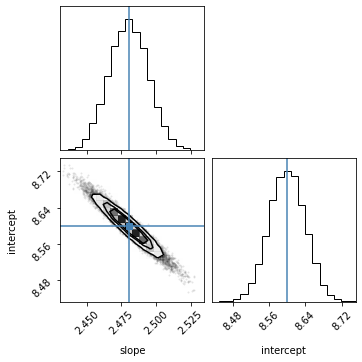

In [ ]:
!pip install corner
# import configparserpl.rcParams["font.size"] = 13
import corner
fig = corner.corner(flat_samples, labels = ["slope", "intercept"], truths = mcmc[:,1]);

soluzione covariante: se si cambia l'intercetta, cambia anche la pendenza e viceversa

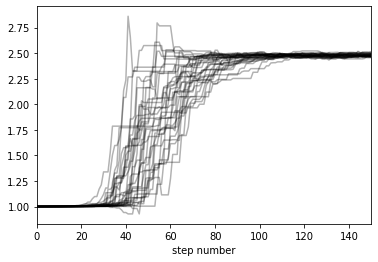

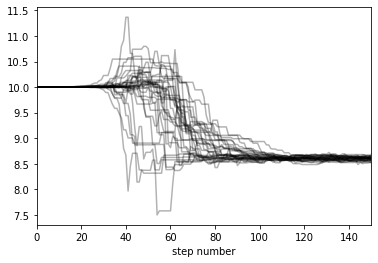

In [ ]:
for i in range(ndim):
  pl.figure()
  pl.plot(samples[:, :, i], "k", alpha = 0.3)
  pl.xlim(0, 150)
  pl.xlabel("step number")

i primi 100 punti si scartano

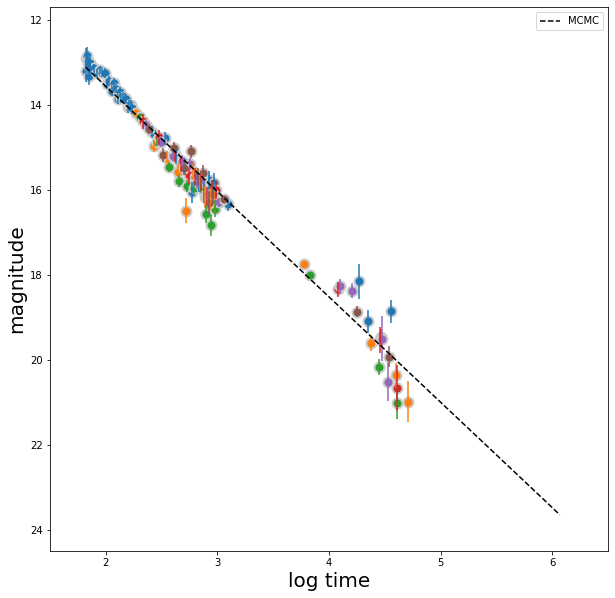

In [ ]:
ax = pl.figure(figsize=(10,10)).add_subplot(111)

for f in grbAG["filter"].unique():
    pl.errorbar(grbAG.loc[grbAG["filter"] == f, "logtime"], 
                grbAG.loc[grbAG["filter"] == f, "mag"], 
                yerr=grbAG.loc[grbAG["filter"] == f, "magerr"], fmt='.', ms=0,
                fcolor=None, label=None)
    
for f in grbAG["filter"].unique():
    pl.scatter(grbAG.loc[grbAG["filter"] == f, "logtime"], 
               grbAG.loc[grbAG["filter"] == f, "mag"], 
               alpha=1, s=100, linewidth=2,
               edgecolor='#cccccc', label=None)
    
ax.plot(grbAG.logtime.values, line(mcmc[0,1], mcmc[1,1], 
                            grbAG.logtime.values), ls="--", c="k", label="MCMC")

pl.ylim(24.5,11.7)
pl.xlim(1.5, 6.5)
pl.ylabel("magnitude", fontsize=20);
pl.xlabel("log time", fontsize=20);
pl.legend();

# Broken Power Law

Transizione smooth tra due diverse pendenze

La variabile è time e non logtime

Punto Tb che determina il passaggio tra una retta di pendenza a1 e una di pendenza a2

$F = \frac{F_0}{(\frac{t}{T_b})^{-a_1} + (\frac{t}{T_b})^{-a_2}}$

$m = b - log_{10}((\frac{t}{T_b})^{-a_1} + (\frac{t}{T_b})^{-a_2})$

In [ ]:
# !pip install emcee
# import emcee

In [ ]:
x = grbAG[grbAG.upperlimit == 0].time.values
y = grbAG[grbAG.upperlimit == 0].mag.values
s = grbAG[grbAG.upperlimit == 0].magerr.values

In [ ]:
def BrokenPowerLaw(a1, a2, Tb, b, x): # 4 parametri
  return b - np.log10((x / Tb) ** (-a1) + (x / Tb) ** (-a2))

prior e likelihood si potrebbero scrivere in modo più generale

In [ ]:
def log_prior_bpl(theta):
  a1, a2, Tb, b = theta
  if a1 > 0 and a2 > 0 and b > 0 and x.min() < Tb < x.max(): # Tb nel range considerato
    return 0.0
  return -np.inf

In [ ]:
def log_likelihood_bpl(theta, x, y, yerr):
  a1, a2, Tb, b = theta
  return - np.sum(((y - BrokenPowerLaw(a1, a2, Tb, b, x)) ** 2 ) / (yerr ** 2))

In [ ]:
def log_probability_bpl(theta, x, y, yerr):
  lp = log_prior_bpl(theta)
  if not np.isfinite(lp):
    return -np.inf
  return lp + log_likelihood_bpl(theta, x, y, yerr)

In [ ]:
ig = [2,   3 , 500,  15] # [a1, a2, Tb, b]

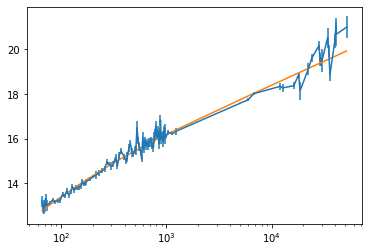

In [ ]:
# alternativa: stochastic gradient descendent optimization per ottenere gli initial guess
from scipy.optimize import minimize
nll = lambda *args: - log_likelihood_bpl(*args)
soln = minimize(nll, ig, args = (x, y, s)) 
ig = soln.x
pl.errorbar(x, y, yerr = s)
pl.plot(x, BrokenPowerLaw(ig[0], ig[1], ig[2], ig[3], x))
pl.xscale("log")

In [ ]:
nwalkers = 32
ndim = len(ig)

In [ ]:
pos = np.array(ig) + 1e-4 * np.random.randn(nwalkers, ndim) 

In [ ]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability_bpl, args = (x, y, s))

In [ ]:
sampler.run_mcmc(pos, 5000, progress = True);

100%|██████████| 5000/5000 [00:14<00:00, 350.58it/s]


In [ ]:
samples = sampler.get_chain()

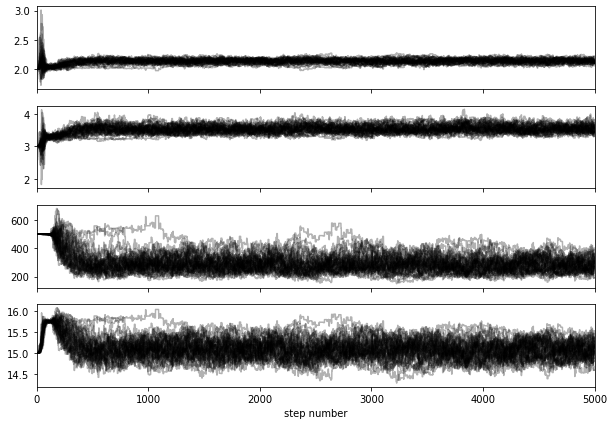

In [ ]:
fig, axes = pl.subplots(ndim, figsize = (10, 7), sharex = True)
for i in range(ndim):
  ax = axes[i]
  ax.plot(samples[:, :, i], "k", alpha = 0.3)
  ax.set_xlim(0, len(samples))
  ax.yaxis.set_label_coords(-0.1, 0.5)
axes[-1].set_xlabel("step number");

In [ ]:
flat_samples = sampler.get_chain(discard = 1000, thin = 15, flat = True)

In [ ]:
mcmc = np.zeros((ndim, 3))
for i in range(ndim):
  mcmc[i] = np.percentile(flat_samples[:, i], [16, 50, 84])

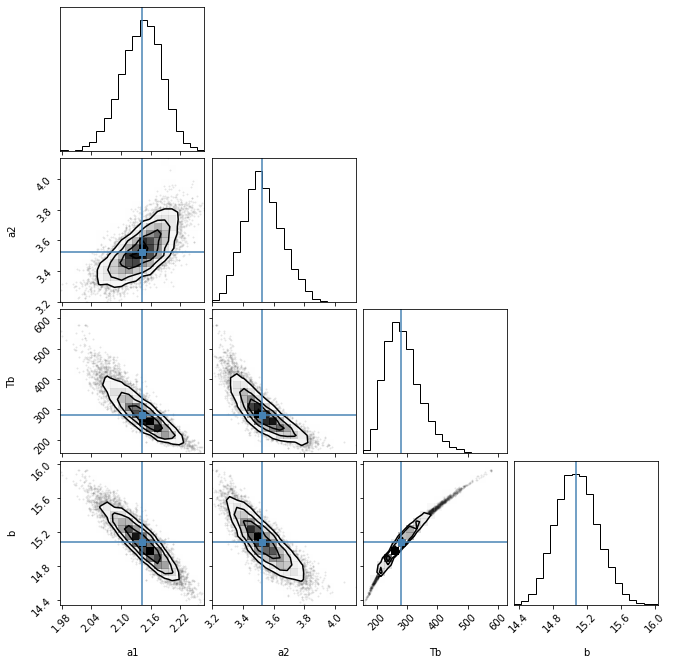

In [ ]:
# !pip install corner
# import corner
fig = corner.corner(flat_samples, labels = ["a1", "a2", "Tb", "b"], truths = mcmc[:,1]); 
# truths segna le linee azzurre

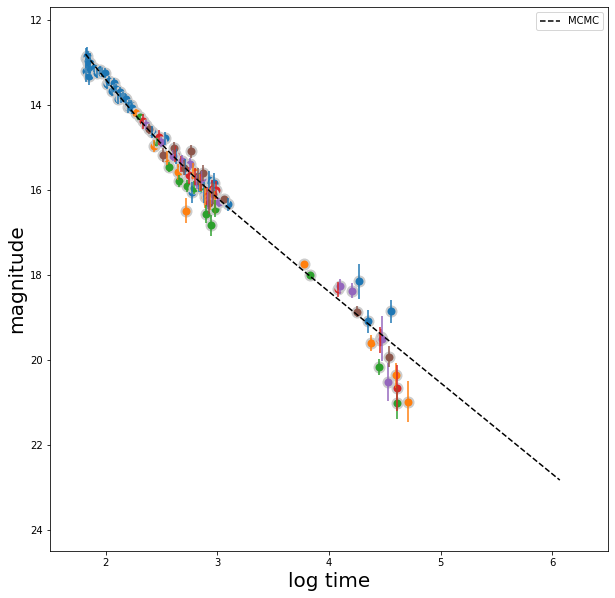

In [ ]:
ax = pl.figure(figsize=(10,10)).add_subplot(111)

for f in grbAG["filter"].unique():
    pl.errorbar(grbAG.loc[grbAG["filter"] == f, "logtime"], 
                grbAG.loc[grbAG["filter"] == f, "mag"], 
                yerr=grbAG.loc[grbAG["filter"] == f, "magerr"], fmt='.', ms=0,
                fcolor=None, label=None)
    
for f in grbAG["filter"].unique():
    pl.scatter(grbAG.loc[grbAG["filter"] == f, "logtime"], 
               grbAG.loc[grbAG["filter"] == f, "mag"], 
               alpha=1, s=100, linewidth=2,
               edgecolor='#cccccc', label=None)
    
ax.plot(grbAG.logtime.values, BrokenPowerLaw(mcmc[0,1], mcmc[1,1], mcmc[2,1], mcmc[3,1],
                            grbAG.time.values), ls="--", c="k", label="MCMC")

pl.ylim(24.5,11.7)
pl.xlim(1.5, 6.5)
pl.ylabel("magnitude", fontsize=20);
pl.xlabel("log time", fontsize=20);
pl.legend();

i punti a dx hanno incertezza maggiore e vengono considerati meno

il punto di cambio pendenza dovrebbe essere più a dx